# Random Forest Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn import tree
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load Split Data

In [2]:
clean_train = "../../data/clean/clean_train.csv"
clean_val = "../../data/clean/clean_val.csv"
clean_test = "../../data/clean/clean_test.csv"
train_subsam = "../../data/clean/train_subsam.csv"
train_smote = "../../data/clean/train_smote.csv"
ran_for_model = "../../model/ranfor_model.joblib"

rnd_rfc = 44
target = "Default"

In [3]:
df_train = pd.read_csv(clean_train, low_memory=False)
df_val = pd.read_csv(clean_val, low_memory=False)
df_test = pd.read_csv(clean_test, low_memory=False)

df_under = pd.read_csv(train_subsam, low_memory=False)
df_smote = pd.read_csv(train_smote, low_memory=False)

In [4]:
X_train = df_train.drop(columns=[target])
X_val = df_val.drop(columns=[target])
X_test = df_test.drop(columns=[target])
X_under = df_under.drop(columns=target)
X_smote = df_smote.drop(columns=target)

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]
y_under = df_under[target]
y_smote = df_smote[target]

In [5]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}\n")

print(f"SubSam: {X_under.shape}, {y_under.shape}")
print(f"SMOTE:  {X_smote.shape}, {y_smote.shape}")

Train: (626670, 18), (626670,)
Val:   (134552, 18), (134552,)
Test:  (134498, 18), (134498,)

SubSam: (219654, 18), (219654,)
SMOTE:  (1033686, 18), (1033686,)


## Model Training

### Model Tuning

In [10]:
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [10, 20, 30],
              "random_state": [rnd_rfc]}

In [ ]:
grid_rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv=10)
grid_rfc.fit(X_train, y_train)

In [ ]:
params = grid_rfc.best_params_

print("Better Parameters:", params)

In [6]:
rfc_model = RandomForestClassifier(criterion="entropy",
                                   max_depth=20,
                                   random_state=rnd_rfc)
rfc_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, random_state=44)

In [7]:
acc_val = rfc_model.score(X_val, y_val)

print("Accuracy Val:", round(acc_val, 4))

Accuracy Val: 0.9479


### Feature Importance

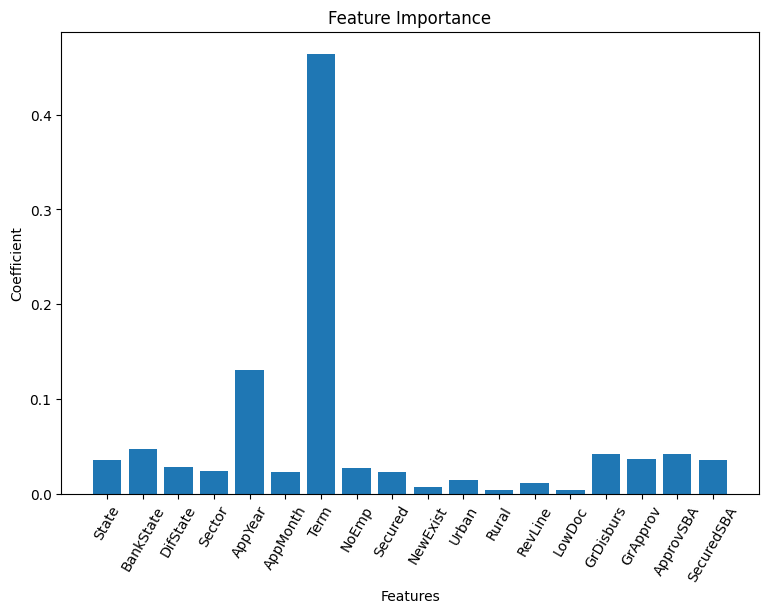

In [8]:
X_cols = X_train.columns
fi_rfc = rfc_model.feature_importances_

plt.figure(figsize=(9, 6))
plt.bar(X_cols, fi_rfc)

plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.xticks(rotation=60)
plt.show()

### Recursive Feature Elimination

In [9]:
rfc_ref = RandomForestClassifier(criterion="entropy",
                                 max_depth=20,
                                 random_state=rnd_rfc)

rfe_rfc = RFE(rfc_ref)
rfe_rfc.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(criterion='entropy', max_depth=20,
                                     random_state=44))

In [10]:
rfe_mat = list(zip(X_train.columns.values.tolist(), rfe_rfc.support_, rfe_rfc.ranking_))
rfe_mat

[('State', True, 1),
 ('BankState', True, 1),
 ('DifState', False, 3),
 ('Sector', True, 1),
 ('AppYear', True, 1),
 ('AppMonth', False, 5),
 ('Term', True, 1),
 ('NoEmp', False, 2),
 ('Secured', False, 4),
 ('NewExist', False, 8),
 ('Urban', False, 6),
 ('Rural', False, 10),
 ('RevLine', False, 7),
 ('LowDoc', False, 9),
 ('GrDisburs', True, 1),
 ('GrApprov', True, 1),
 ('ApprovSBA', True, 1),
 ('SecuredSBA', True, 1)]

In [11]:
sel_cols = [tupla[1] for tupla in rfe_mat]
rfe_cols = X_train.loc[:, sel_cols].columns
rfe_cols

Index(['State', 'BankState', 'Sector', 'AppYear', 'Term', 'GrDisburs',
       'GrApprov', 'ApprovSBA', 'SecuredSBA'],
      dtype='object')

In [12]:
rfc_ref.fit(X_train[rfe_cols], y_train)

RandomForestClassifier(criterion='entropy', max_depth=20, random_state=44)

In [13]:
y_ref = rfc_ref.predict(X_val.loc[:,sel_cols])
acc_ref = accuracy_score(y_val, y_ref)

print("Accuracy REF:", round(acc_ref, 4))

Accuracy REF: 0.9493


### Balanced Datasets

**Subsample Dataset**

In [14]:
rfc_under = RandomForestClassifier(criterion="entropy",
                                   max_depth=20,
                                   random_state=rnd_rfc)
rfc_under.fit(X_under[rfe_cols], y_under)

RandomForestClassifier(criterion='entropy', max_depth=20, random_state=44)

In [15]:
acc_under = rfc_under.score(X_val[rfe_cols], y_val)

print("Accuracy SubSampling:", round(acc_under, 4))

Accuracy SubSampling: 0.9093


**SMOTE Dataset**

In [16]:
rfc_smote = RandomForestClassifier(criterion="entropy",
                                   max_depth=20,
                                   random_state=rnd_rfc)
rfc_smote.fit(X_smote[rfe_cols], y_smote)

RandomForestClassifier(criterion='entropy', max_depth=20, random_state=44)

In [17]:
acc_smote = rfc_smote.score(X_val[rfe_cols], y_val)

print("Accuracy SMOTE:", round(acc_smote, 4))

Accuracy SMOTE: 0.9149


## Model Evaluation

### Cross-Validation

**Testing the Model**

In [18]:
results = cross_val_score(rfc_ref, X_test[rfe_cols], y_test, cv=10)

print("Results:", results)
print("Accuracy Test (mean +/- desv): %0.4f +/- %0.4f" % (results.mean(), results.std()))

Results: [0.94513011 0.94200743 0.94275093 0.94453532 0.94275093 0.94565056
 0.94394052 0.94312268 0.94631571 0.94542345]
Accuracy Test (mean +/- desv): 0.9442 +/- 0.0014


In [19]:
y_cv_test = cross_val_predict(rfc_ref, X_test[rfe_cols], y_test, cv=10)
acc_cv_test = accuracy_score(y_test, y_cv_test)

print("Accuracy Test:", round(acc_cv_test, 4))

Accuracy Test: 0.9442


**Model Scores**

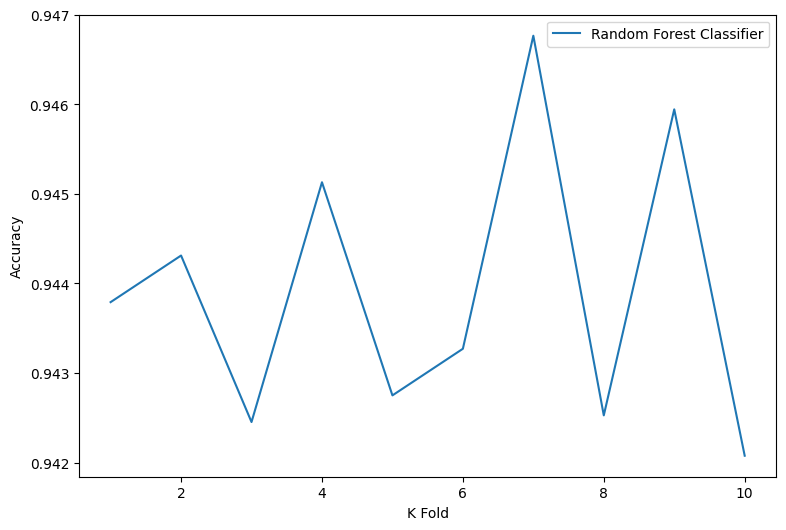

In [21]:
kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(rfc_ref, X_test[rfe_cols], y_test, cv=kf, scoring="accuracy")

plt.figure(figsize=(9, 6))
plt.plot(range(1, 11), scores, label="Random Forest Classifier")

plt.xlabel("K Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Classification Metrics

**Classification Report**

In [22]:
y_pred = rfc_ref.predict(X_test[rfe_cols])

In [23]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9490
Precisión:    0.9235
Sensibilidad: 0.8976
F1-score:     0.9099


In [24]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9614    0.9772    0.9692    110629
           1     0.8856    0.8181    0.8505     23869

    accuracy                         0.9490    134498
   macro avg     0.9235    0.8976    0.9099    134498
weighted avg     0.9479    0.9490    0.9482    134498



**Confusion Matrix**

In [25]:
cm_rfc = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_rfc)

[[0.80378147 0.01875121]
 [0.03228301 0.14518432]]


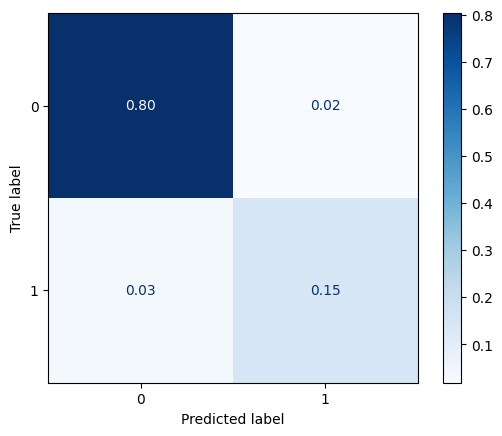

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfc,
                              display_labels=rfc_ref.classes_)
disp.plot(cmap="Blues", values_format=".2f")

**ROC (Receiver Operating Characteristic) Curve**

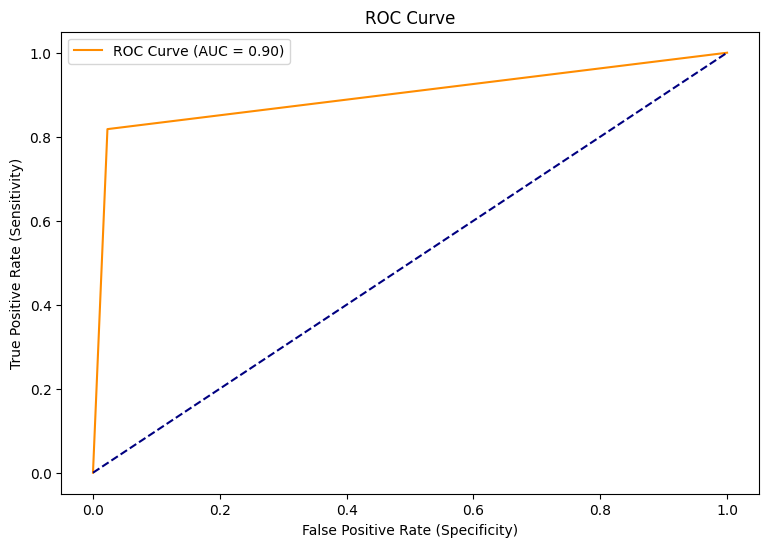

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

## Model Pipeline

### Create the Pipeline

In [28]:
class RandomForestModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ranfor = RandomForestClassifier(criterion="entropy",
                                             max_depth=20,
                                             random_state=rnd_rfc)
        self.pred_cols = ["State", "BankState", "Sector", "AppYear", "Term", 
                          "GrDisburs", "GrApprov", "ApprovSBA", "SecuredSBA"]

    def fit(self, X, y):
        self.ranfor.fit(X[self.pred_cols], y)
        return self

    def predict(self, X, y=None):
        X_ = X[self.pred_cols].copy()
        y_pred = self.ranfor.predict(X_)
        return y_pred

In [29]:
ranfor_custom = Pipeline([
    ("custom_model", RandomForestModel())
    ])

### Test the Pipeline

**Internal Partition**

In [30]:
ranfor_custom.fit(X_train, y_train)

y_pred = ranfor_custom.predict(X_val)

In [31]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.9493
Precisión:    0.9232
Sensibilidad: 0.8989
F1-score:     0.9104


**External Partition**

In [32]:
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

ranfor_custom.fit(X_train_val, y_train_val)

y_pred = ranfor_custom.predict(X_test)

In [33]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9494
Precisión:    0.9241
Sensibilidad: 0.8987
F1-score:     0.9107


**The Best Model**

In [34]:
ranfor_custom.fit(X_train_val, y_train_val)

y_pred = ranfor_custom.predict(X_test)

In [35]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.9494
Precisión:    0.9241
Sensibilidad: 0.8987
F1-score:     0.9107


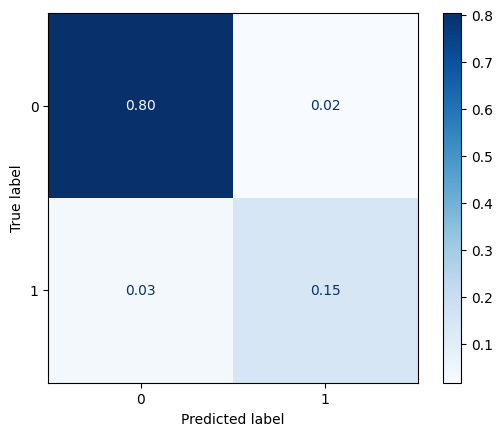

In [36]:
cm_dtc = confusion_matrix(y_test, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtc,
                              display_labels=rfc_ref.classes_)
disp.plot(cmap="Blues", values_format=".2f")

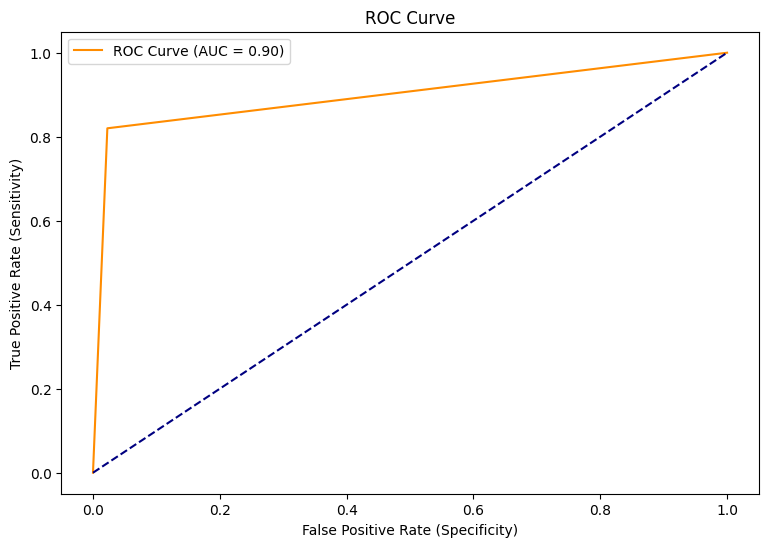

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

### Save the Model

In [38]:
try:
    joblib.dump(ranfor_custom, ran_for_model)

    ranfor_model = joblib.load(ran_for_model)
    print(f"Random Forest Classifier is loaded...")

except Exception as err:
    print("Error:", str(err))

Random Forest Classifier is loaded...


In [39]:
y_pred = ranfor_model.predict(X_test)
df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)

In [40]:
df_.sample(10)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,Pred
125945,24,30,1,20,13,3,120,12,0,0,0,0,0,0,415000,415000,373500,90,1,1
74824,21,24,0,19,42,4,84,2,0,0,1,0,1,0,295555,75000,37500,50,0,0
93015,34,17,1,12,43,6,84,1,0,0,1,0,1,0,25300,25300,12650,50,0,0
111051,16,19,0,20,28,4,70,31,0,0,0,0,0,0,241000,241000,200030,83,0,0
28582,43,17,1,13,36,7,36,2,0,0,1,0,1,0,25000,25000,12500,50,0,0
131031,43,47,0,1,47,5,36,1,0,0,0,1,0,0,38000,38000,19000,50,0,0
13046,34,37,0,20,31,6,180,5,0,0,0,0,0,0,420000,420000,315000,75,0,0
4590,34,30,1,4,39,9,14,2,0,0,1,0,1,0,42599,18000,9000,50,1,1
67200,15,18,0,16,39,12,84,3,0,0,1,0,0,0,145500,145500,72750,50,0,0
109164,32,45,1,20,23,3,84,65,0,0,0,0,0,0,250000,250000,200000,80,1,1
